# Standalone Notebook Analysis of Magnetospheric State Query System (MSQS) data
## Objective:
To generate an appropriate prediction model capable of using solar wind driver parameters to predict magnetospheric state response parameters  
This model uses the linear correlation assumption to generate linear coefficients ($\overline {b}$) and intercepts (${a}$) for the formulas:  
$Kp_{ijkn} = a_0 + b_0 * x_{Psw} + b_1 * x_{Bmag} + b_2 * x_{Bz} + b_3 * x_{Vsw}$  
$AE_{ijknp} = a_0 + b_0 * x_{Psw} + b_1 * x_{Bmag} + b_2 * x_{Bz} + b_3 * x_{Vsw} + b_4 * x_{Kp}$  
$Dst_{ijknpq} = a_0 + b_0 * x_{Psw} + b_1 * x_{Bmag} + b_2 * x_{Bz} + b_3 * x_{Vsw} + b_4 * x_{Kp} + b_5 * x_{AE}$
### Specified parameters:  
Driver parameters:
* Psw - Solar wind pressure
* Bmag - Magnitude of Interplanetary Magnetic Field (IMF) vector
* Bz - North-South component of IMF
* Vsw - Solar wind speed

Driver & response parameters:
* Kp - Planetary Geomagnetic Activity Index
* Ae - Auroral Electrojet Index

Response parameters:
* Dst - Storm-time disturbance index

Regression Models:
- **Multiple Linear Regression**
- ~~Generalized Least Squares (builds covariance matrix of size (# observations)^2; only for small samples)~~
- ~~Ordinary Least Squares~~
- ~~Ridge Regression (for highly correlated independent variables)~~
- ~~Lasso Regression (shrinks coefficient values to near zero)~~
- ~~Quantile Regression (when linear regression requirements not met or outliers in data)~~

## Changelog:  
6/14/22:
- Create notebook
- New section: retrieving data (publicly)
- New section: importing into dataframe

6/15/22:
- Edit create database: filter on relevant fields, replace fill values with null values, rename fields appropriately

6/21/22:
- Fix code to new revised objective: incorporate binning of parameters
- New section: time shifting
- Revised section: looping through each bin while freeing 1 parameter

6/22/22:
- Continue work on parameter shuffling component
- Added progress indicator

6/23/22:
- Continue work on parameter shuffling
- Added component to build linear regression models for parameter settings which produce data
- Bug fixing
- Freeze all parameters for each iteration except the chosen free floating variable and Dst

6/25/22:
- Reduce dataset size for testing by random sampling
- Reduced scope of machine learning by only learning on 2-3 variables instead of all 6
- Continue testing on finding coefficients...

6/27/22:
- Continue testing on finding coefficients by running possible coefficients through dataframe
- Assign additional columns regarding model size (and its transformations) to learning models (as weights to coefficients)
- High variability in frequency plot for coefficients and intercepts (several hundred?)

6/28/22:
- Write descriptions and explanations for machine learning code (Pre-processing and learning)

6/29/22:
- Add additional log transformation function to model size
- Comparing variability of different transformation functions applied to model size (plot) (Kp has the most variability)
- Outputs for parameter coefficients each for the different transformation functions with all using 100% of provided data

7/2/22:
- Considering different ways to split data
- Using random sampling on dataset results in incredibly varied outputs (?)
- More experimentation needed

7/3/22:
- Calculate prediction Dst values given coefficients; highly variable errors
- Tweak model size weight functions to reduce error using minimizer function
- Plot predicted Dst values against actual Dst values

7/5/22:
- Investigate cause for inaccuracies
- Debugging main source code

7/6/22:
- Tweaked documentation
- More debugging

7/7/22:
- Sample various time indices to compare measured and predicted Dst
- Residual plot between actual and predicted Dst is not evenly distributed, may be due to outlier skew(?)

7/8/22:
- Tweaking with different sample sizes
- Comparing different sample size coefficients

7/11/22:
- Save bin interval combinations for each coefficient
- Code clean-up (Push hard-coded adjustable values to top)

7/12/22:
- Included code to extract coefficients given a configuration of bin parameters
- Change model to pull first 100,000 entries as training data instead of random sampling

7/13/22:
- Continuing to work on transforming data to read indices of bin parameters and be able to calculate coefficients for all valid bin parameters

7/14/22:
- Issue: Manual update of finding coefficients and determining Dst estimate
- Work on updating for all possible combinations

7/15/22:
- Continued work on updating possible combinations
- Add tracking for valid combinations with data
- Testing/debugging

8/3/22:
- Code bug fixing, clean-up, and more small tweaks everywhere
- Continuous review of code logic

8/4/22:
- Logic fixing, add comments
- More testing/debugging

8/5/22:
- Testing performance and accuracy
- Added conventional, built-in multiple linear regression modeler from sklearn

8/8/22:
- Nothing (Prepare presentation)

8/11/22:
- Build database to store coefficients for every bin combination
- Make Dst predictions on test data from the coefficient database
- Will need to condense/simplify code and add comments/explanations
- Need to run testing for data during storm events (extreme low Dst values)

8/12/22:
- Run testing for specific time intervals and plot graphs of predictions and measured values over time

8/15/22:
- Need to convert model to be able to predict Kp and AE values as well
- Work on making model flexible enough to use appropriate driver and response parameters

8/16/22:
- Continue adjusting various parts designed for only Dst as response parameter to utilize the match variable to change its function accordingly

8/17/22:
- Finish adjusting model and run testing for all of Kp, AE, and Dst

8/18/22:
- Still need to write comments/documentation
- Need to allow easy flexibility in changing the data range (indices) for training and testing
- Code clean-up

8/19/22:
- Small tweaks
- Code clean-up

8/22/22:
- Code clean-up
- Comments

8/23/22:
- Comments
- Small tweaks

8/24/22:
- Markdown documentation revision
- Small tweaks

8/25/22:
- Added more easily configurable datetime plotter
- Comments
- Markdown documentation revision
- Copy notebook into separate .py file
- Add additional tester.ipynb to import .py file

## Package Imports
* Data manipulation  
* Machine Learning Modeler  
* Data visualization (graphs/plots)  
* Utilities

In [1]:
# Data manipulation
import numpy as np # For calculations and use of numpy arrays for better efficiency
import pandas as pd # For store and organize data as pandas databases
# Machine learning
from sklearn.linear_model import LinearRegression # Main machine learning model to determine linear coefficients
from sklearn.metrics import mean_squared_error # To determine the mean squared error between prediction values and actual values

# Plotting
import matplotlib.pyplot as plt # For plotting data
import seaborn as sns # Alternative way of plotting data

# Utilities
from datetime import datetime, time # For converting individual dates, times, and hours to an easily (pandas/matplotlib) readable datetime format
from itertools import pairwise,product # Allows forming interval pairs given threshold boundaries and creating an iterable for every bin combination
from scipy.optimize import minimize_scalar

# Package options (disable warnings)
pd.options.mode.chained_assignment = None # Default to "warn"; To disable the warning caused by chained index calls on pandas series/databases

In [2]:
!pip list

Package              Version
-------------------- ---------
anyio                3.5.0
appdirs              1.4.4
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
asttokens            2.2.1
attrs                21.4.0
Babel                2.9.1
backcall             0.2.0
beautifulsoup4       4.12.2
bleach               4.1.0
Bottleneck           1.3.5
brotlipy             0.7.0
certifi              2023.7.22
cffi                 1.15.1
charset-normalizer   2.0.4
colorama             0.4.6
comm                 0.1.2
contourpy            1.0.5
cryptography         38.0.4
cycler               0.11.0
debugpy              1.6.6
decorator            5.1.1
defusedxml           0.7.1
entrypoints          0.4
executing            1.2.0
fastjsonschema       2.15.1
fonttools            4.25.0
idna                 3.3
ipykernel            6.20.2
ipython              8.9.0
ipython-genutils     0.2.0
jedi                 0.18.2
Jinja2               3.0.3
joblib               1.1.0
json5      

## Model Configuration Constants
* MATCH
* CHANGE_MODEL_SIZE_THRESHOLD
* matplotlib graph label sizes

In [3]:
# Response variable to match from driver variables
MATCH = 'Kp (n/a)' # from ['Kp (n/a)','AE (hourly) (nT)','Dst (nT)']

# Above the threshold for the sample size, the machine learning linear regression estimation is used
# Otherwise, the arithmetic mean estimation is used
CHANGE_MODEL_SIZE_THRESHOLD = 80

# Matplotlib graph label size configurations
plt.rc('font', size=100) # controls default text sizes
plt.rc('axes', titlesize=24) # fontsize of the axes title
plt.rc('axes', labelsize=20) # fontsize of the x and y labels
plt.rc('xtick', labelsize=20) # fontsize of the tick labels
plt.rc('ytick', labelsize=20) # fontsize of the tick labels
plt.rc('legend', fontsize=16) # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

## Pre-processing
* Configure boundary thresholds for each variable
* Form bin intervals as pairs (tuples) for each variable  
Binning Intervals:  
$P_{SW} = [\leq0.5;\gt0.5-2.5;\gt2.5-4.5;\gt4.5-6.5;\gt6.6-8.5;\gt8.5-15;\gt15]$  
$Bmag_{SW} = [\leq3;\gt3-6;\gt6-9;\gt9-20;\gt20]$  
$Bz_{k_{SW}} = [\leq-15;\gt-15--5;\gt-5-0;\gt0-5;\gt5-15;\gt15]$  
$V_{SW} = [\leq300;\gt300-400;\gt400-500;\gt500-600;\gt600-700;\gt700]$  
$AE = [0-100;\gt100-300;\gt300-600;\gt600-900;\gt900-1200;\gt1200]$  
$K_{p} = [0-0.5;\gt0.5-1.5;\gt1.5-2.5;\gt2.5-3.5;\gt3.5-4.5;\gt4.5-5.5;\gt5.5-6.5;\gt6.5]$  
$Dst = [\leq-200;\gt-200--100;\gt-100--50;\gt-50--30;\gt-30-0;\gt0-20;\gt20]$
* Dictionaries to match each interval to its index for each variable
* Lists of names for all parameters, input parameters, and output parameters
* Dictionary of appropriate time shifts for each response parameter
* Set matplotlib graph label size configurations

In [4]:
# Bin boundaries/thresholds (Ex. [-inf, 3, 6,...,inf] bmag)
p_bins = [-np.inf,0.5,2.5,4.5,6.5,8.5,15,np.inf] # 7 intervals
bmag_bins = [-np.inf,3,6,9,20,np.inf] # 5 intervals
bz_bins = [-np.inf,-15,-5,0,5,15,np.inf] # 6 intervals
v_bins = [-np.inf,300,400,500,600,700,np.inf] # 6 intervals
ae_bins = [-0.001,100,300,600,900,1200,np.inf] # 6 intervals*
kp_bins = [-0.001,0.5,1.5,2.5,3.5,4.5,5.5,6.5,np.inf] # 8 intervals*
dst_bins = [-np.inf,-200,-100,-50,-30,0,20,np.inf] # 7 intervals

boundaries = [p_bins,bmag_bins,bz_bins,v_bins,kp_bins,ae_bins,dst_bins] # List of bin boundaries for each variable
# *Note: AE and Kp intervals use -0.001 instead of 0 to include 0 within the interval

# Bin intervals (Ex. [(-inf,3),(3,6),...,(20,inf)] bmag)
bins = [list(pairwise(b)) for b in boundaries] # List of bin intervals for each variable

# Array of dictionaries matching the interval to its index (Ex. (-inf,3) -> 0; (3,6) -> 1; ... ; (20,inf) -> 4) (for bmag)
indices = []
for b in bins:
    interval_indices = {}
    for idx, interval in enumerate(b):
        interval_indices[interval] = idx
    interval_indices[(-np.inf, np.inf)] = -1
    indices.append(interval_indices)
    
# Lists of names of parameters
parameters = ['SW Flow Pressure (nPa)','SW Bmag (nT)','SW Bz (nT)','SW Velocity (km/sec)','Kp (n/a)','AE (hourly) (nT)','Dst (nT)'] # Name of parameters in order of provided bins
io_index = parameters.index(MATCH) # The index of the response parameter in the list of all parameters
input_parameters = parameters[:io_index] # List of all input parameters excluding the response parameter
output_parameters = parameters[io_index] # The output parameter (should just be one)

# How much to time shift the driver parameters to match the corresponding response parameters (by hours)
time_shifts = {
    'Kp (n/a)': {
        'SW Flow Pressure (nPa)': 0, # Default 0 hours
        'SW Bmag (nT)': 0, # 0 hours
        'SW Bz (nT)': 1, # 1 hour
        'SW Velocity (km/sec)': 0, # 0 hours
        'Kp (n/a)': 0, # 0 hours
        'AE (hourly) (nT)': 0 # 0 hours
    },
    'AE (hourly) (nT)': {
        'SW Flow Pressure (nPa)': 0, # Default 0 hours
        'SW Bmag (nT)': 0, # 0 hours
        'SW Bz (nT)': 1, # 1 hour
        'SW Velocity (km/sec)': 0, # 0 hours
        'Kp (n/a)': 0, # 0 hours
        'AE (hourly) (nT)': 0 # 0 hours
    },
    'Dst (nT)': {
        'SW Flow Pressure (nPa)': 2, # Default 2 hours
        'SW Bmag (nT)': 2, # 2 hours
        'SW Bz (nT)': 3, # 3 hours
        'SW Velocity (km/sec)': 2, # 2 hours
        'Kp (n/a)': 2, # 2 hours
        'AE (hourly) (nT)': 2 # 2 hours
    }
}

### Retrieving available data (if data does not already exist)
To retrieve public MSQS data:
1. Pull public MSQS data from https://omniweb.gsfc.nasa.gov/ow.html as .lst and .fmt files
2. Convert files into formatted .csv file (Excel) (.lst -> .txt -> .xlsx -> .csv)

### Create database
Read csv file into pandas dataframe  
Replace fill values with NaN (Not a Number) values  
Specific fill values for each category can be referenced from https://omniweb.gsfc.nasa.gov/html/ow_data.html#3  
Included data:
* Driver parameters:
    * Psw - Solar wind pressure
    * Bmag - Magnitude of Interplanetary Magnetic Field (IMF) vector
    * Bz - North-South component of IMF
    * Vsw - Solar wind speed
* Driver & response parameters:
    * Kp - Planetary Geomagnetic Activity Index
    * Ae - Auroral Electrojet Index
* Response parameters:
    * Dst - Storm-time disturbance index

In [5]:
# Read local csv file (must be in same directory as this file)
raw_df = pd.read_csv('omni2_h8ZIWOAzck.csv')

# Relevant fields in data pulling from the raw data
fields = [
    'Year',
    'DOY',
    'Hour',
    'Flow pressure',
    'Vector B Magnitude,nT',
    # 'BX, nT (GSE, GSM)',
    # 'BY, nT (GSM)',
    'BZ, nT (GSM)',
    'SW Plasma Speed, km/s',
    'Kp index',
    'AE-index, nT',
    'Dst-index, nT',
    # 'R (Sunspot No.)',
    # 'f10.7_index',
    # 'SW Plasma Temperature, K',
    # 'SW Proton Density, N/cm^3',
    # 'E elecrtric field', # Is misspelled in .csv file
    # 'Plasma Beta',
    # 'Quasy-Invariant',
    # 'Alfen mach number',
    # 'AL-index, nT',
    # 'AU-index, nT',
    # 'ap_index, nT',
    # 'pc-index'
]

# Fill values for each category where the data is null or missing (these values in the categories represent missing values and should be replaced by null)
fill_values = {
    'Flow pressure': 99.99,
    'Vector B Magnitude,nT': 999.9,
    'SW Plasma Speed, km/s': 9999.,
    'BX, nT (GSE, GSM)': 999.9,
    'BY, nT (GSM)': 999.9,
    'BZ, nT (GSM)': 999.9,
    'SW Plasma Speed, km/s': 9999.,
    'Kp index': 99,
    'Dst-index, nT': 99999,
    'AE-index, nT': 9999,
    # 'SW Plasma Temperature, K': 9999999.,
    # 'Plasma Beta': 999.99,
    # 'Quasy-Invariant': 9.9999,
    # 'Alfen mach number': 999.9,
    # 'AL-index, nT': 99999,
    # 'AU-index, nT': 99999,
    # 'ap_index, nT': 999,
    # 'pc-index': 999.9
}

# Renames for each category
renames = {
    'DOY':'Decimal Day',
    'Hour':'hour:min',
    'Flow pressure': 'SW Flow Pressure (nPa)',
    'Vector B Magnitude,nT': 'SW Bmag (nT)',
    'BX, nT (GSE, GSM)': 'SW Bx (nT)',
    'BY, nT (GSM)': 'SW By (nT)',
    'BZ, nT (GSM)': 'SW Bz (nT)',
    'SW Plasma Speed, km/s': 'SW Velocity (km/sec)',
    'Kp index': 'Kp (n/a)',
    'Dst-index, nT': 'Dst (nT)',
    'AE-index, nT': 'AE (hourly) (nT)',
    # 'R (Sunspot No.)': 'Sunspot Number R (n/a)',
    # 'f10.7_index': 'F10.7 (10^-22 Joul/sec/m^2/Hz)',
    # 'SW Plasma Temperature, K': 'SW Proton Temperature (K)', # May not match
    # 'SW Proton Density, N/cm^3': 'SW Proton Density (/cc)',
    # 'E elecrtric field': 'SW Electric Field (mV/m)',
    # 'Plasma Beta': 'Plasma Beta (n/a)',
    # 'Quasy-Invariant': 'Quasi-Invariant (n/a)',
    # 'Alfen mach number': 'Alfven Mach Number (n/a)',
    # 'AL-index, nT': 'AL (hourly) (nT)',
    # 'AU-index, nT': 'AU (hourly) (nT)',
    # 'ap_index, nT': 'AP Index (nT)',
    # 'pc-index': 'PC(N) Index (n/a)'
}

# Replace the specific fill values with null for each category appropriately, and rename the categories appropriately
raw_df = raw_df.replace(fill_values, np.nan)[fields].rename(columns=renames)

# Kp data from imported data is multiplied by 10 to be in integer format
# Readjust Kp data by dividing by 10 and converting to decimal/float
if(raw_df['Kp (n/a)'].dtypes == 'int64'):
    raw_df['Kp (n/a)'] = raw_df['Kp (n/a)']/10.

df = raw_df # Copy dataframe into another dataframe before time shifting

### Database set-up cont.
Time shift each column appropriately:  
For Kp & AE:  
* $Bz_{t-1} \sim Kp_{t} \sim AE_{t}$

For Dst:
* $V_{SW_{t-2}} \sim B_{mag_{t-2}} \sim P_{SW_{t-2}} \sim Dst_{t}$
* $Kp_{t-2} \sim AE_{t-2} \sim Dst_{t}$
* $Bz_{t-3} \sim Dst_{t}$


Drop all entries with missing values  
Combine time columns to one easily readable (by pandas and matplotlib) format  
Split training and testing data from modified dataframe

In [6]:
# Retrieve columns from SW Flow Pressure to Dst and time shift each column appropriately
for col_name in df.columns[3:9]:
    df[col_name] = df[col_name].shift(time_shifts[MATCH][col_name])

df = df.dropna() # Drop all entries where there are any missing values in any of the columns
# dataframe df should have 288249 rows after

# Combine date and time columns to one datetime column (Ex. year:1999, day:25, hour:22 => 199902506 => 1999-06-25 22:00:00)
df['datetime'] = pd.to_datetime(df['Year'] * 100000 + df['Decimal Day'] * 100 + df['hour:min'], format='%Y%j%H') # YYYYDDDHH

# Use first 100,000 entries as training data and rest as testing data (arbitrary)
train = df[:100000]
test = df[100000:]

## Multiple Linear Regression
Multi-parameter Linear Equations:  
$Kp_{ijkn} = a_0 + b_0 * x_{Psw} + b_1 * x_{Bmag} + b_2 * x_{Bz} + b_3 * x_{Vsw}$  
$AE_{ijknp} = a_0 + b_0 * x_{Psw} + b_1 * x_{Bmag} + b_2 * x_{Bz} + b_3 * x_{Vsw} + b_4 * x_{Kp}$  
$Dst_{ijknpq} = a_0 + b_0 * x_{Psw} + b_1 * x_{Bmag} + b_2 * x_{Bz} + b_3 * x_{Vsw} + b_4 * x_{Kp} + b_5 * x_{AE}$  

Assumptions of Regression Model:
1. ~~Linearity (Assumption made in building model)~~
2. Homoscedasticity
3. Independence
4. Normality

## Main Machine learning code
### Pre-processing:  
- Initialize the response parameter estimate column
- Set bin indices for response parameter and unused parameters to (-inf, inf)
- Initialize storage for coefficient sets of each bin combination

### Learning:
- Binning combinations:
    - Data is split for each possible combination of the variables (each iteration, data is stored in loc)
    - Not all combinations result in data output, only combinations with at least one data point will be processed through learning model
    - (One known combination: p:(-infinity,0.5), bmag:(3,6), bz:(0,5), v:(300,400), ae:(0,100), kp:(0.5,1.5), dst:(0,20); 0 1 3 1 0 1 5 )
- Model building:
    - Pull data within all the bin parameters
    - Only the response variables and unused variables should have their bin parameters set to (-infinity, infinity)
    - Build linear regression model with (all of) the filtered data by fitting the input parameters with the output parameters
        - The model determines the linear coefficients for each input parameter to the output parameter including the intercept simultaneously
    - Return the linear regression coefficients, intercept, and model size for each successful model built
- Structure:
    - Iterate through every possible bin combination for all of the variables
        - If there is data from a certain bin combination, build a linear model and store its linear coefficients in coeff_df
        - Also updates the result dataframe with the response parameter estimate given the linear equations

In [7]:
%%time

# Copy training data to result data and add response parameter estimate
result = train
result[MATCH + ' est'] = np.nan

# Appropriately set bin indices for the response parameter to -inf, inf
if MATCH == 'Dst (nT)':
    boundaries[6] = [-np.inf,np.inf] # Dst boundaries
elif MATCH == 'AE (hourly) (nT)':
    boundaries[6] = [-np.inf,np.inf] # Dst boundaries
    boundaries[5] = [-np.inf,np.inf] # AE boundaries
elif MATCH == 'Kp (n/a)':
    boundaries[6] = [-np.inf,np.inf] # Dst boundaries
    boundaries[5] = [-np.inf,np.inf] # AE boundaries
    boundaries[4] = [-np.inf,np.inf] # Kp boundaries

# Counter for number of coefficient sets stored, initialize coefficient sets size to 9000 (arbitrary)
coeff_iter = 0
coeffs = np.empty((9000, 10 + len(input_parameters)))

# Form an iterable object cycling through all the possible bin combination intervals
# Form list of intervals between each boundary for each variable
# Make complete list of all combination of intervals for each variable
# Iterate through each combination
product_pairs = product(pairwise(boundaries[0]),pairwise(boundaries[1]),pairwise(boundaries[2]),pairwise(boundaries[3]),pairwise(boundaries[4]),pairwise(boundaries[5]),pairwise(boundaries[6]))
for p_interval,bmag_interval,bz_interval,v_interval,kp_interval,ae_interval,dst_interval in product_pairs:
    # clear_output(wait=True)
    
    # Retrieve the data for a bin combination and store as loc
    # Get data with Dst and the current free variable as free and the other variables restricted to bins
    # Each of the parameter limits are stored in p_interval, bmag_interval,...,dst_interval
    # If a parameter is set to be free, then the parameter interval is set to (-infinity,infinity)

    # The below statement returns data within the boundaries of a bin parameter combination...
    # which is then run for each possible combination...
    # which is repeated for setting a different parameter to be free
    loc = train.loc[(train['SW Flow Pressure (nPa)']>p_interval[0]) & (train['SW Flow Pressure (nPa)']<=p_interval[1]) & 
            (train['SW Bmag (nT)']>bmag_interval[0]) & (train['SW Bmag (nT)']<=bmag_interval[1]) &
            (train['SW Bz (nT)']>bz_interval[0]) & (train['SW Bz (nT)']<=bz_interval[1]) &
            (train['SW Velocity (km/sec)']>v_interval[0]) & (train['SW Velocity (km/sec)']<=v_interval[1]) &
            (train['Kp (n/a)']>kp_interval[0]) & (train['Kp (n/a)']<=kp_interval[1]) &
            (train['AE (hourly) (nT)']>ae_interval[0]) & (train['AE (hourly) (nT)']<=ae_interval[1]) &
            (train['Dst (nT)']>dst_interval[0]) & (train['Dst (nT)']<=dst_interval[1])]
    
    # If there is data for the bin combination, make a linear regression model to fit the input parameters with the output parameters
    if loc.shape[0] > 0:
        lin_regr = LinearRegression()
        lin_regr.fit(loc[input_parameters],loc[output_parameters])
        
        # Calculates the estimates for the output parameter according to whichever output parameter is assigned
        # The column of response estimates are calculated according to the linear equations given previously
        if MATCH == 'Dst (nT)':
            loc['Dst (nT) est'] = (loc['SW Flow Pressure (nPa)'] * lin_regr.coef_[0] \
                + loc['SW Bmag (nT)'] * lin_regr.coef_[1] \
                + loc['SW Bz (nT)'] * lin_regr.coef_[2] \
                + loc['SW Velocity (km/sec)'] * lin_regr.coef_[3] \
                + loc['Kp (n/a)'] * lin_regr.coef_[4] \
                + loc['AE (hourly) (nT)'] * lin_regr.coef_[5] \
                + lin_regr.intercept_)
        elif MATCH == 'AE (hourly) (nT)':
             loc['AE (hourly) (nT) est'] = (loc['SW Flow Pressure (nPa)'] * lin_regr.coef_[0] \
                + loc['SW Bmag (nT)'] * lin_regr.coef_[1] \
                + loc['SW Bz (nT)'] * lin_regr.coef_[2] \
                + loc['SW Velocity (km/sec)'] * lin_regr.coef_[3] \
                + loc['Kp (n/a)'] * lin_regr.coef_[4] \
                + lin_regr.intercept_)
        else:
            loc['Kp (n/a) est'] = (loc['SW Flow Pressure (nPa)'] * lin_regr.coef_[0] \
                + loc['SW Bmag (nT)'] * lin_regr.coef_[1] \
                + loc['SW Bz (nT)'] * lin_regr.coef_[2] \
                + loc['SW Velocity (km/sec)'] * lin_regr.coef_[3] \
                + lin_regr.intercept_)
        
        interval_indices = [indices[idx][interval] for idx, interval in enumerate([p_interval, bmag_interval, bz_interval, v_interval, kp_interval, ae_interval, dst_interval])]
        
        coeffs[coeff_iter] = interval_indices + list(lin_regr.coef_) + [lin_regr.intercept_, loc[MATCH].mean(), loc.shape[0]]
        
        result.update(loc, overwrite=False)
        coeff_iter += 1
    
coeffs.resize((coeff_iter), 10 + len(input_parameters))

# Approximate runtime: 7 min
# Size of coeffs: 4906 sets of coefficients for Dst

CPU times: total: 48.7 s
Wall time: 9.52 s


### Build coefficients dataframe
Coefficients for every bin combination  
Each entry has a bin index for all parameters, coefficients for all input parameters, intercept, the arithmetic mean for the output parameter, and the model/sample size

In [8]:
columns = ['SW Flow Pressure (nPa)', 'SW Bmag (nT)', 'SW Bz (nT)', 'SW Velocity (km/sec)', 'Kp (n/a)', 'AE (hourly) (nT)', 'Dst (nT)'] \
            + [s + ' coeff' for s in input_parameters] \
            + ['intercept', 'arithmetic_mean', 'model_size']
coeff_df = pd.DataFrame(coeffs, columns=columns).convert_dtypes()
coeff_df.sort_values('model_size', ascending = False)

,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),SW Flow Pressure (nPa) coeff,SW Bmag (nT) coeff,SW Bz (nT) coeff,SW Velocity (km/sec) coeff,intercept,arithmetic_mean,model_size
79,1,1,2,1,-1,-1,-1,0.250538,0.133798,-0.285663,0.008052,-2.708183,1.602836,6912
85,1,1,3,1,-1,-1,-1,0.269773,0.138254,-0.071913,0.005986,-2.095052,0.982593,6756
80,1,1,2,2,-1,-1,-1,0.370087,0.111657,-0.349715,0.007071,-2.468478,2.297329,5540
86,1,1,3,2,-1,-1,-1,0.446687,0.126555,-0.091693,0.0055,-2.070487,1.559959,5302
109,1,2,3,1,-1,-1,-1,0.31708,0.152364,-0.136779,0.006418,-2.285115,1.32654,2792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,5,4,5,1,-1,-1,-1,0.0,0.0,0.0,0.0,4.0,4.0,1
296,3,0,1,3,-1,-1,-1,0.0,0.0,0.0,0.0,4.0,4.0,1
509,4,4,0,5,-1,-1,-1,0.0,0.0,0.0,0.0,8.0,8.0,1
505,4,4,0,1,-1,-1,-1,0.0,0.0,0.0,0.0,6.3,6.3,1


In [9]:
# Convert list of indices to list of corresponding intervals
# Ex. [0, 0, 2, 0, 0, 0, -1] -> [(-inf, 0.5), (-inf, 3), (-5, 0), (-inf, 300), (-0.001, 0.5), (-0.001, 100), (-inf, inf)]
def index_to_interval(indices, bins):
    intervals = []
    for index, b in zip(indices, bins):
        if int(index) == -1:
            intervals.append((-np.inf, np.inf))
        else:
            intervals.append(b[int(index)])
        
    return intervals

In [10]:
test[MATCH + ' est'] = np.nan

for idx, row in coeff_df.iterrows():
    loc_indices = list(row[['SW Flow Pressure (nPa)','SW Bmag (nT)','SW Bz (nT)','SW Velocity (km/sec)','Kp (n/a)','AE (hourly) (nT)', 'Dst (nT)']])
    loc_intervals = index_to_interval(loc_indices, bins)
    
    loc = test.loc[(test['SW Flow Pressure (nPa)']>loc_intervals[0][0]) & (test['SW Flow Pressure (nPa)']<=loc_intervals[0][1]) & 
            (test['SW Bmag (nT)']>loc_intervals[1][0]) & (test['SW Bmag (nT)']<=loc_intervals[1][1]) &
            (test['SW Bz (nT)']>loc_intervals[2][0]) & (test['SW Bz (nT)']<=loc_intervals[2][1]) &
            (test['SW Velocity (km/sec)']>loc_intervals[3][0]) & (test['SW Velocity (km/sec)']<=loc_intervals[3][1]) &
            (test['Kp (n/a)']>loc_intervals[4][0]) & (test['Kp (n/a)']<=loc_intervals[4][1]) &
            (test['AE (hourly) (nT)']>loc_intervals[5][0]) & (test['AE (hourly) (nT)']<=loc_intervals[5][1]) &
            (test['Dst (nT)']>loc_intervals[6][0]) & (test['Dst (nT)']<=loc_intervals[6][1])]
    if loc.shape[0] > 0:
        if row['model_size'] > CHANGE_MODEL_SIZE_THRESHOLD:
            coeffs = list(row[[s + ' coeff' for s in input_parameters]])
            
            if MATCH == 'Dst (nT)':
                loc['Dst (nT) est'] = (loc['SW Flow Pressure (nPa)'] * coeffs[0] \
                    + loc['SW Bmag (nT)'] * coeffs[1] \
                    + loc['SW Bz (nT)'] * coeffs[2] \
                    + loc['SW Velocity (km/sec)'] * coeffs[3] \
                    + loc['Kp (n/a)'] * coeffs[4] \
                    + loc['AE (hourly) (nT)'] * coeffs[5] \
                    + row['intercept'])
            elif MATCH == 'AE (hourly) (nT)':
                 loc['AE (hourly) (nT) est'] = (loc['SW Flow Pressure (nPa)'] * coeffs[0] \
                    + loc['SW Bmag (nT)'] * coeffs[1] \
                    + loc['SW Bz (nT)'] * coeffs[2] \
                    + loc['SW Velocity (km/sec)'] * coeffs[3] \
                    + loc['Kp (n/a)'] * coeffs[4] \
                    + row['intercept'])
            else:
                loc['Kp (n/a) est'] = (loc['SW Flow Pressure (nPa)'] * coeffs[0] \
                    + loc['SW Bmag (nT)'] * coeffs[1] \
                    + loc['SW Bz (nT)'] * coeffs[2] \
                    + loc['SW Velocity (km/sec)'] * coeffs[3] \
                    + row['intercept'])

        else:
            loc[MATCH + ' est'] = row['arithmetic_mean']
            
        test.update(loc, overwrite=False)

# Compute prediction errors between predicted values and actual values
test[MATCH + ' diff'] = (test[MATCH] - test[MATCH + ' est'])

# Reformat data in dataframe to most fitting data format
test = test.convert_dtypes()

# Results
Resulting test dataframe with parameter estimates and differences between estimates and actual

In [11]:
test

,Year,Decimal Day,hour:min,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),datetime,Kp (n/a) est,Kp (n/a) diff
231795,1996,163,3,1.52,3.4,0.3,338,1.0,64,3,1996-06-11 03:00:00,0.786704,0.213296
231796,1996,163,4,1.58,2.8,-0.1,339,1.0,58,6,1996-06-11 04:00:00,0.769511,0.230489
231797,1996,163,5,1.99,4.0,-0.4,341,1.0,57,7,1996-06-11 05:00:00,1.185704,-0.185704
231798,1996,163,6,2.53,3.7,1.1,344,1.0,67,11,1996-06-11 06:00:00,1.138514,-0.138514
231799,1996,163,7,2.84,3.2,1.5,352,1.0,144,13,1996-06-11 07:00:00,1.197282,-0.197282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425107,2018,181,19,1.2,3.3,2.5,460,0.7,44,-6,2018-06-30 19:00:00,1.18383,-0.48383
425108,2018,181,20,1.08,3.4,-1.9,454,0.7,62,-7,2018-06-30 20:00:00,2.18545,-1.48545
425109,2018,181,21,0.93,3.7,0.2,451,1.0,114,-10,2018-06-30 21:00:00,1.275243,-0.275243
425110,2018,181,22,0.85,3.7,-0.2,431,1.0,103,-9,2018-06-30 22:00:00,1.376683,-0.376683


In [12]:
# (# entries with a valid estimation for the response parameter, # entries with no estimation)
test[test[MATCH + ' est'].notnull()].shape[0], test[test[MATCH + ' est'].isnull()].shape[0]

(187889, 360)

In [13]:
test[test[MATCH + ' est'].notnull()].reindex(test[test[MATCH + ' est'].notnull()][MATCH + ' diff'].abs().sort_values().index) # Sorted by increasing estimation error

,Year,Decimal Day,hour:min,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),datetime,Kp (n/a) est,Kp (n/a) diff
306855,2005,2,15,1.97,7.8,-5.4,710,5.7,1129,-32,2005-01-02 15:00:00,5.7,0.0
370391,2012,93,23,0.34,5.3,-5.1,324,1.7,364,-37,2012-04-02 23:00:00,1.7,0.0
385902,2014,9,6,0.48,6.7,5.3,402,1.3,173,-16,2014-01-09 06:00:00,1.3,0.0
282353,2002,77,17,18.01,3.7,14.3,467,3.3,117,59,2002-03-18 17:00:00,3.3,0.0
304191,2004,257,15,0.11,10.8,3.5,289,0.3,35,3,2004-09-13 15:00:00,0.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310043,2005,135,11,4.99,50.0,21.9,961,7.7,349,-175,2005-05-15 11:00:00,2.8,4.9
307230,2005,18,6,0.84,9.4,13.5,556,7.7,489,-55,2005-01-18 06:00:00,2.615714,5.084286
265287,2000,97,15,1.74,6.2,0.4,368,6.7,185,-21,2000-04-06 15:00:00,1.518307,5.181693
303021,2004,208,21,1.18,3.8,1.1,595,7.3,195,-42,2004-07-26 21:00:00,2.112348,5.187652


In [14]:
# mean squared error between actual response values vs predicted response values (smaller = more accurate)
mean_squared_error(test[test[MATCH + ' est'].notnull()][MATCH].astype('float64'),test[test[MATCH + ' est'].notnull()][MATCH + ' est'].astype('float64'))

0.5544235298847863

In [15]:
test[MATCH + ' diff'].mean(), test[MATCH + ' diff'].std()

(-0.19535311989195453, 0.7185147431595873)

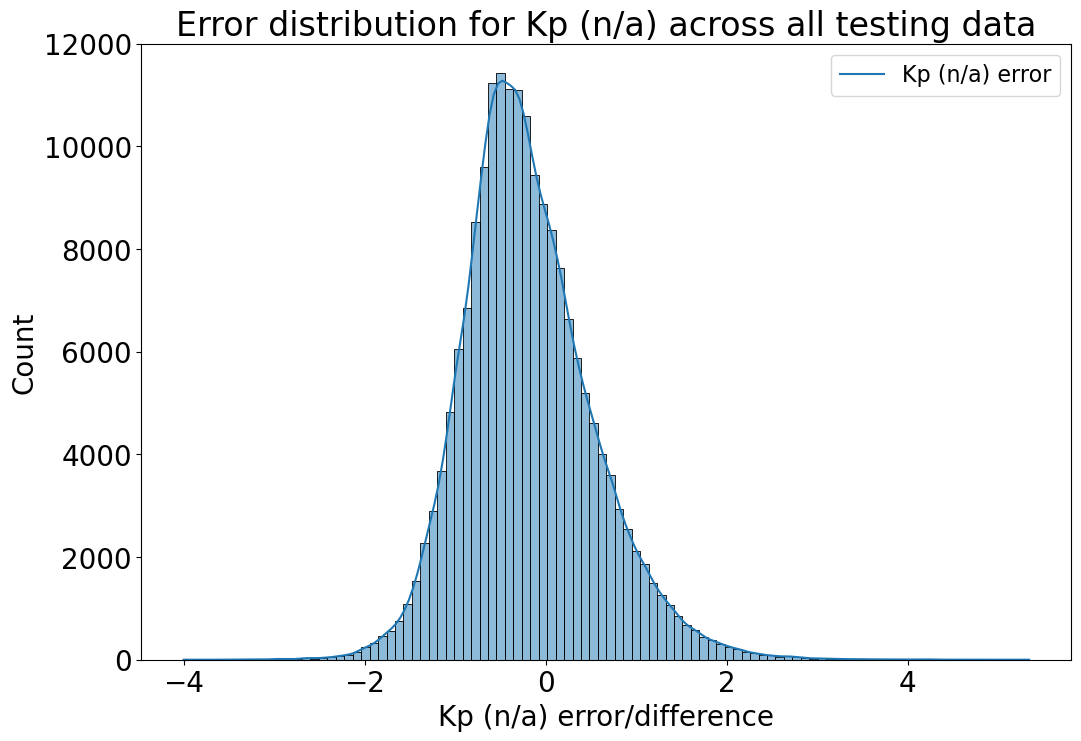

In [16]:
plt.figure(figsize=(12,8))
sns.histplot(test[MATCH + ' diff'], kde=True, bins=100)
plt.legend([MATCH + ' error'])
#plt.xlim((-100,100))
plt.xlabel(MATCH + ' error/difference')
plt.title('Error distribution for '+MATCH+' across all testing data')
plt.show()

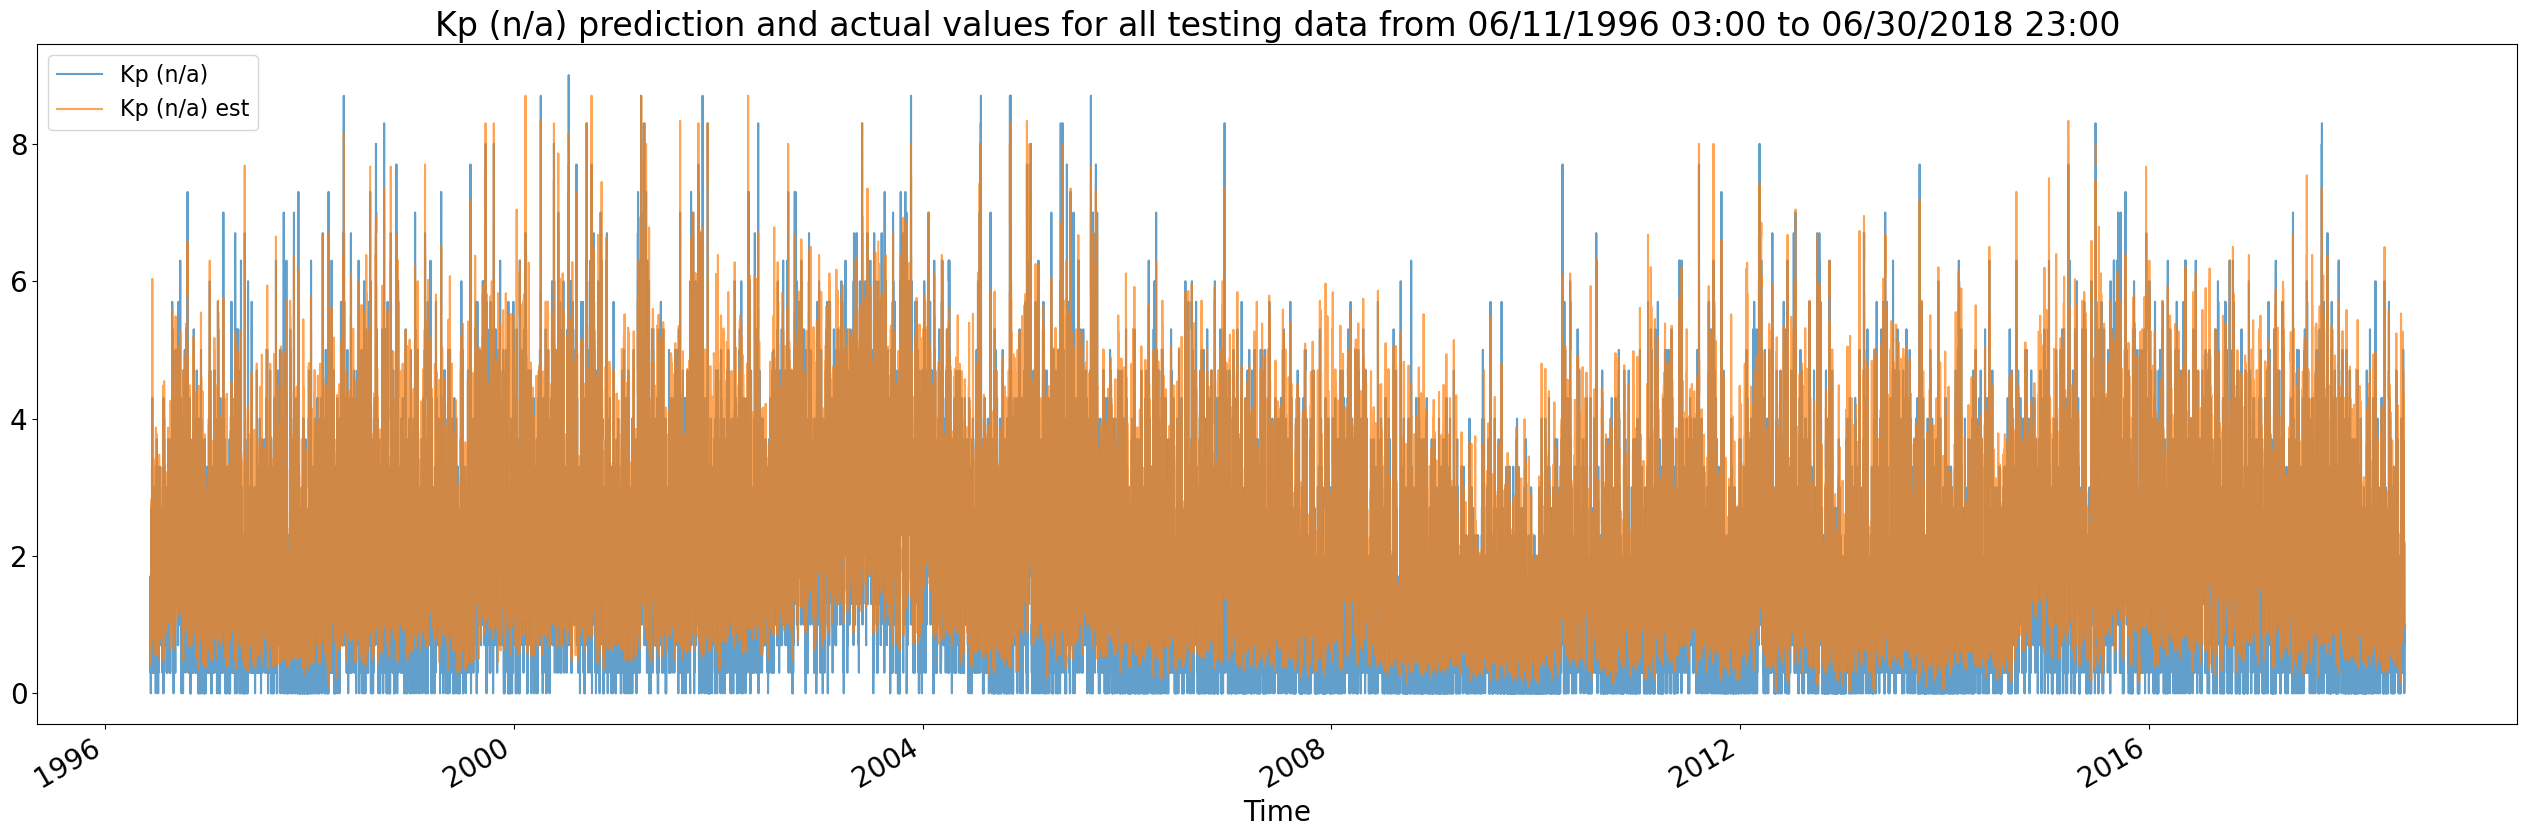

In [17]:
plt.figure(figsize=(32,10))

# alpha to set opacity
test.set_index('datetime')[MATCH].plot(alpha=0.7)
test.set_index('datetime')[MATCH + ' est'].plot(alpha=0.7)

#plt.ylim((-500,500))
plt.xlabel('Time')
plt.title(MATCH + ' prediction and actual values for all testing data from '+test['datetime'].iloc[0].strftime('%m/%d/%Y %H:%M')+' to '+test['datetime'].iloc[-1].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

### Configurable datetime range graphs

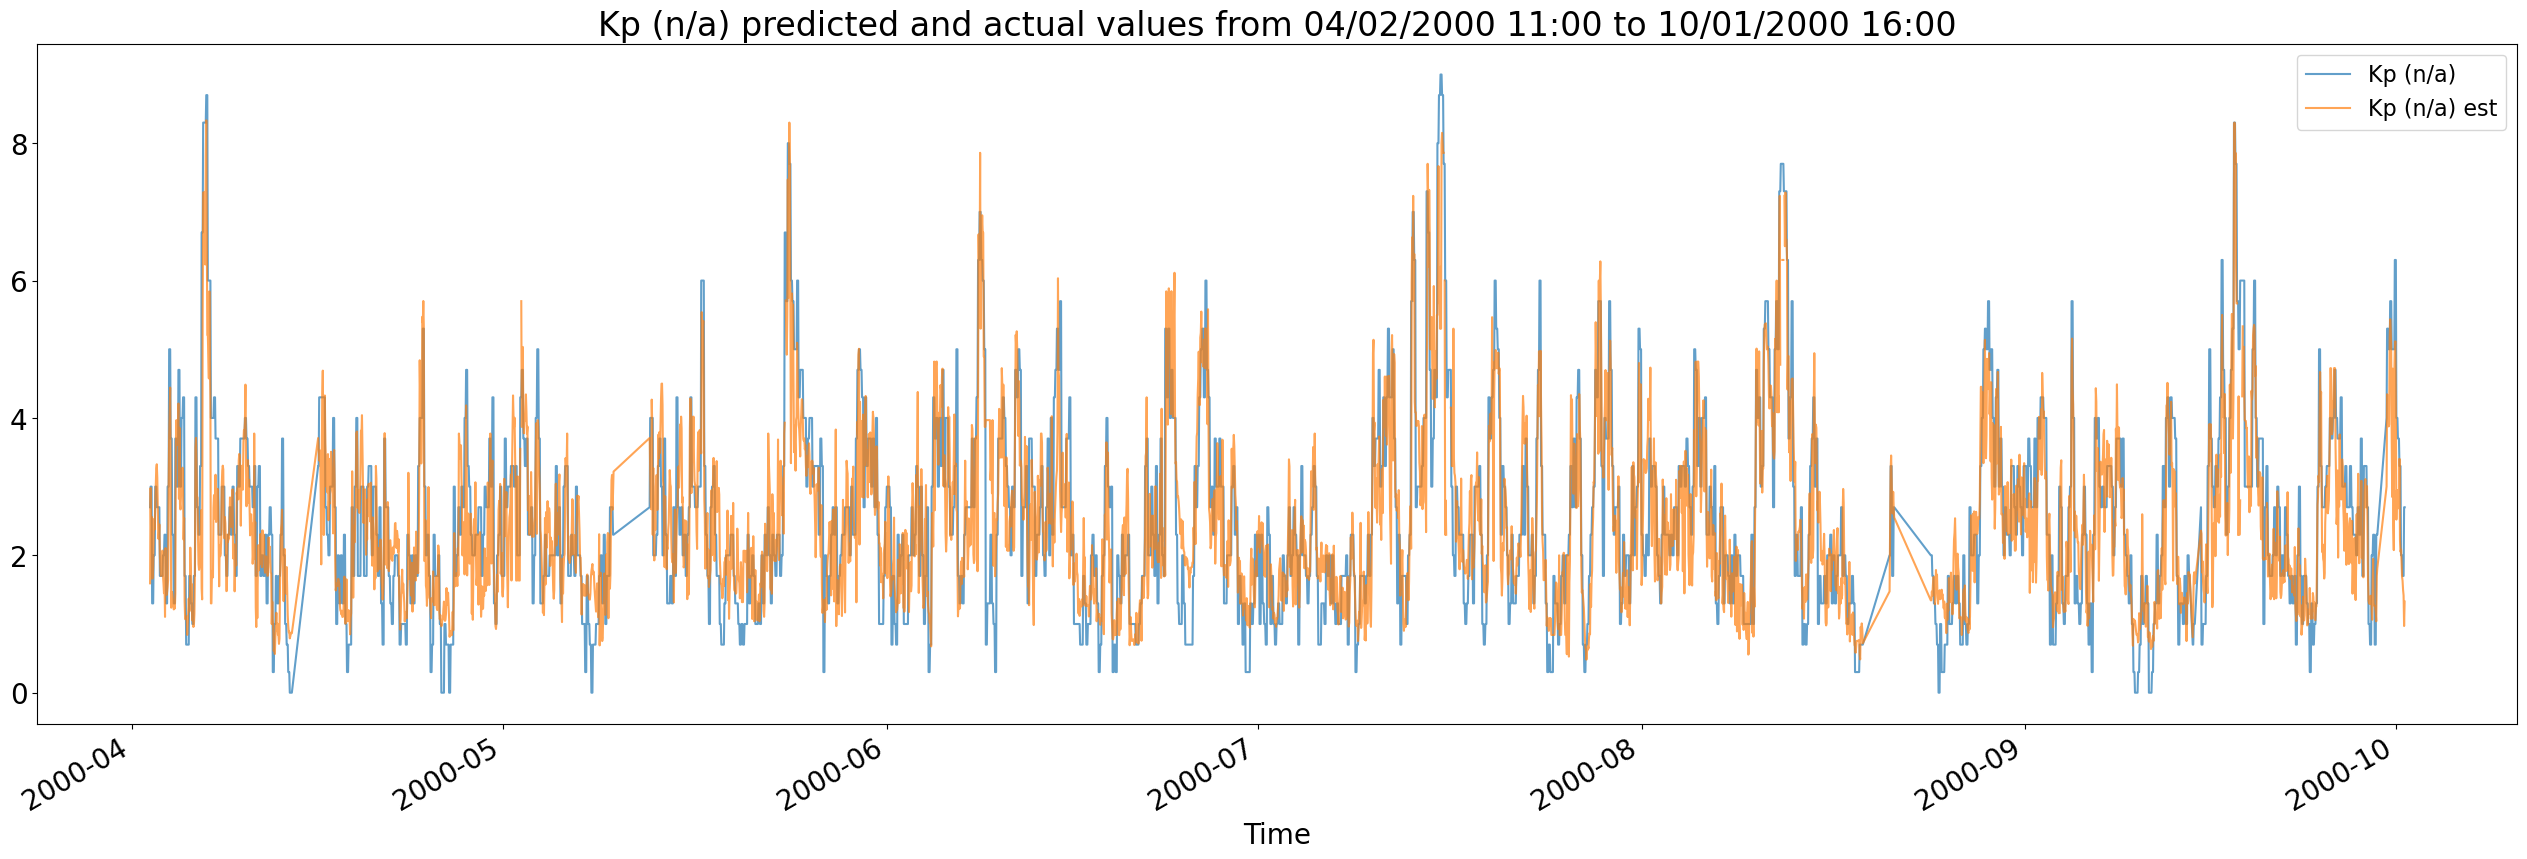

In [18]:
plt.figure(figsize=(32,10))

time_interval = (datetime(2000, 4, 2, 11, 0),datetime(2000, 10, 1, 16, 0)) # Configurable datetime(year, month, day, hour, min)
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

test.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7) # alpha to set opacity
test.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-320,100))
plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+time_interval[0].strftime('%m/%d/%Y %H:%M')+' to '+time_interval[1].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

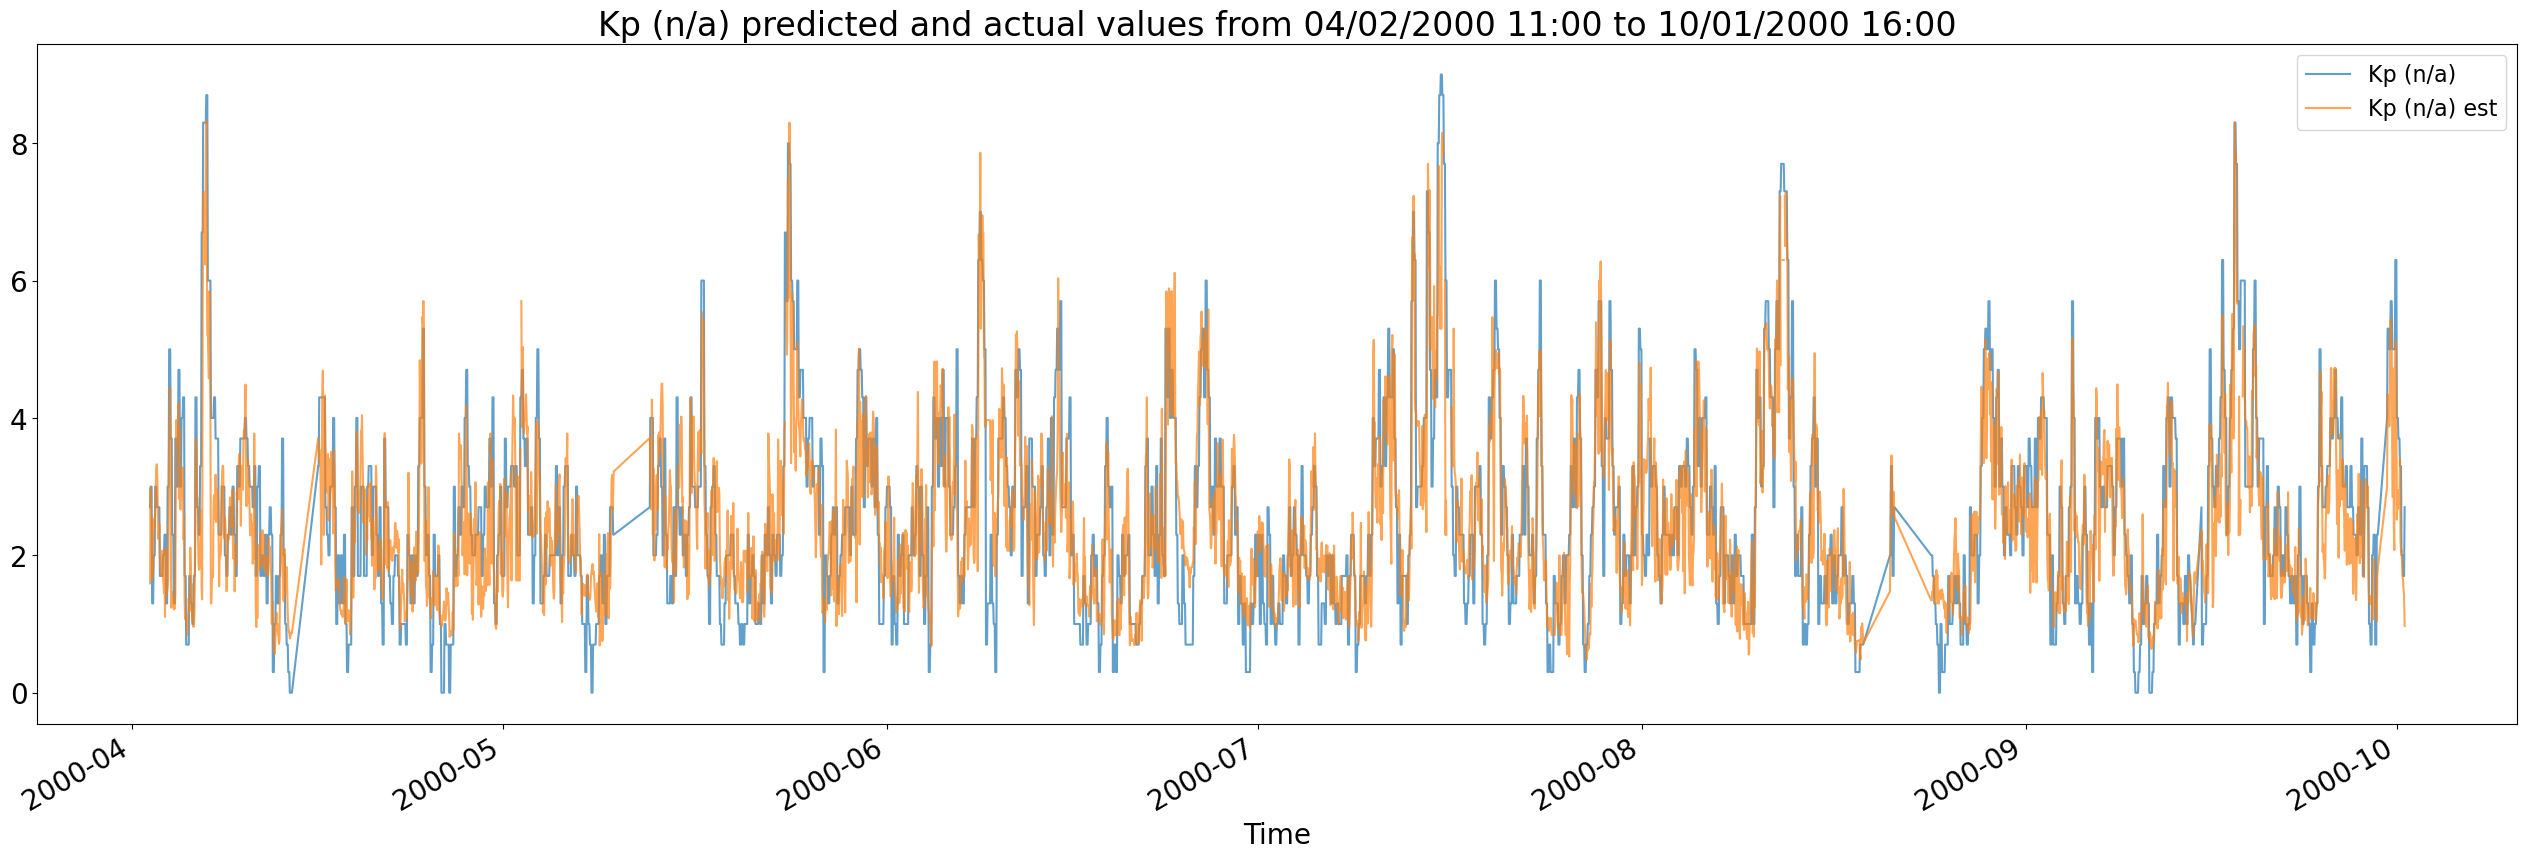

In [19]:
plt.figure(figsize=(32,10))

time_interval = (32400,36500) # By index
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

test.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7)
test.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-320,100))
plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+test['datetime'].iloc[time_interval[0]].strftime('%m/%d/%Y %H:%M')+' to '+test['datetime'].iloc[time_interval[1]].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

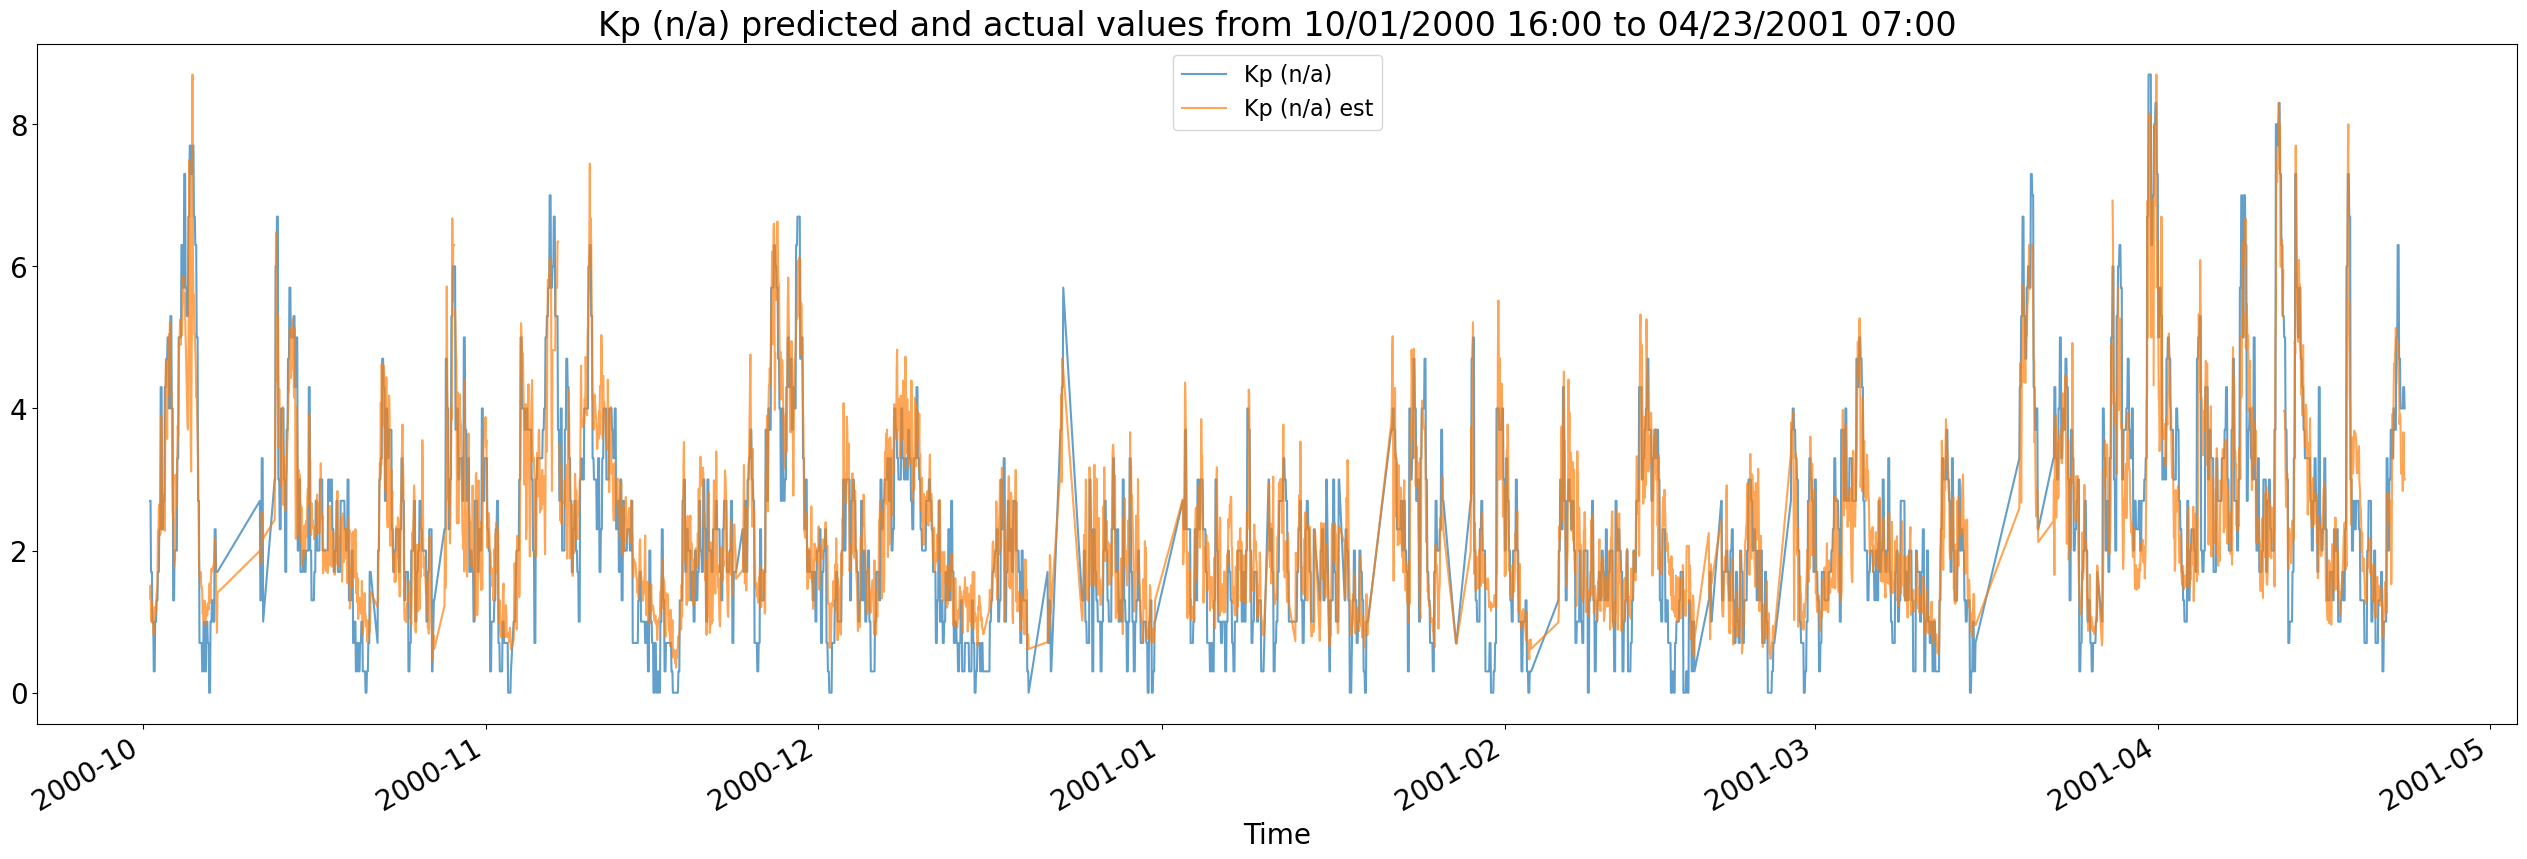

In [20]:
plt.figure(figsize=(32,10))

time_interval = (36500,40600) # By index
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

test.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7)
test.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-420,100))
plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+test['datetime'].iloc[time_interval[0]].strftime('%m/%d/%Y %H:%M')+' to '+test['datetime'].iloc[time_interval[1]].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

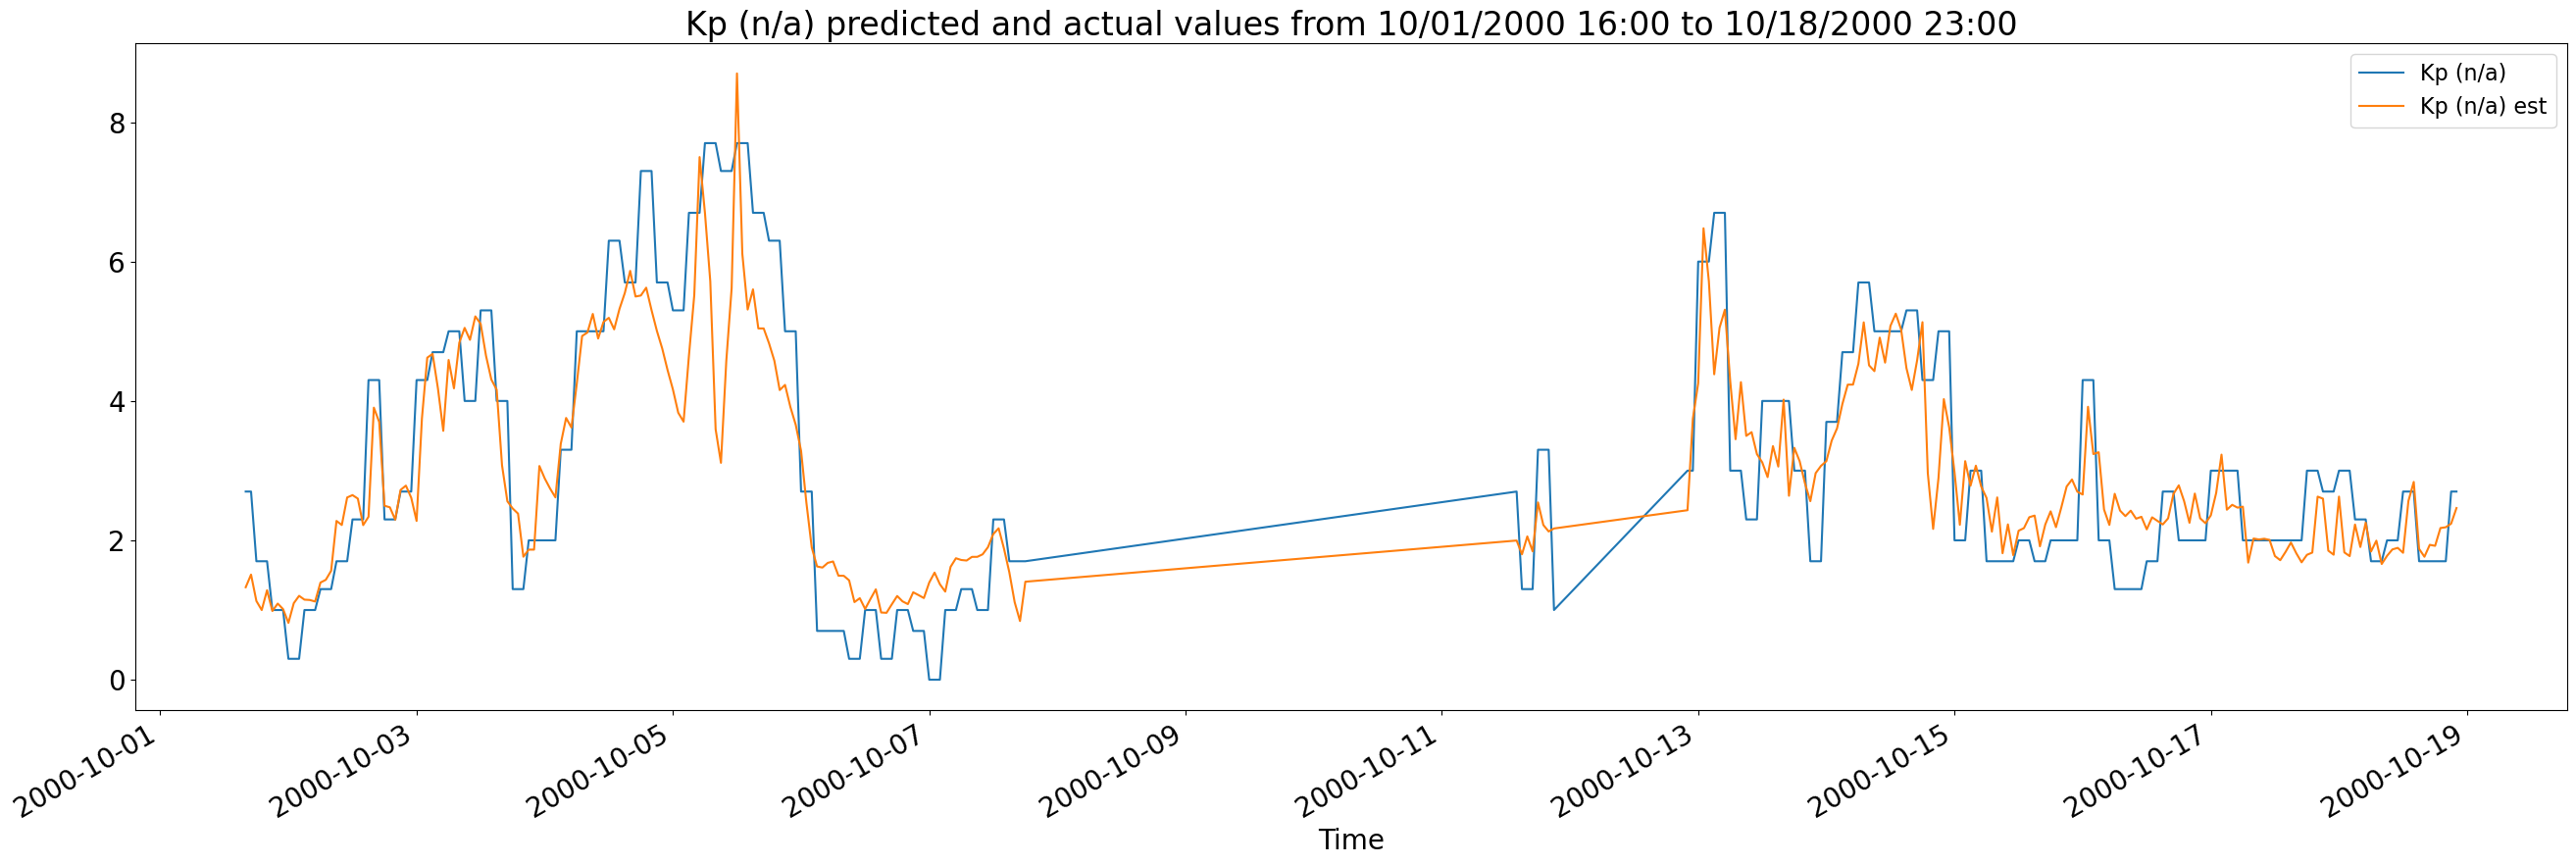

In [21]:
plt.figure(figsize=(32,10))

time_interval = (36500,36800) # By index
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

test.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot()
test.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot()

#plt.ylim((-420,100))
plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+test['datetime'].iloc[time_interval[0]].strftime('%m/%d/%Y %H:%M')+' to '+test['datetime'].iloc[time_interval[1]].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

### ~~UNUSED Weighted means computations~~
~~Compute weighted means of coefficients using different function transformations of the sample size~~

In [22]:
def weight_func(x, df, coeff):
    df['Dst est'] = (df['SW Flow Pressure (nPa)'] * coeff[0] \
        + df['SW Bmag (nT)'] * coeff[1] \
        + df['SW Bz (nT)'] * coeff[2] \
        + df['SW Velocity (km/sec)'] * coeff[3] \
        + df['Kp (n/a)'] * coeff[4] \
        + df['AE (hourly) (nT)'] * coeff[5]
        + x )
    return mean_squared_error(df['Dst (nT)'],df['Dst est'])

def power_func(x):
    power_weight_means = []

    for variable_data in regression_data:
        regr_df = pd.DataFrame(variable_data, columns=['coefficient','intercept','model_size','free_var','p_interval','bmag_interval','bz_interval','v_interval','kp_interval','ae_interval','dst_interval'])
        regr_df['model_size_power'] = np.power(regr_df['model_size'],x)

        power_weight_mean = np.sum(regr_df['coefficient']*regr_df['model_size_power']/np.sum(regr_df['model_size_power']))
        power_weight_means.append(power_weight_mean)
    
    m = minimize_scalar(weight_func, args=(df, power_weight_means))
    return m.fun

# m2 = minimize_scalar(power_func)
# mse = m2.fun
# power = m2.x
# m2 # fun: mean squared error; x: power yielding lowest mean squared error

In [23]:
def config_data(df, i, j, k, n, p, q):
    return df.loc[((df['SW Flow Pressure (nPa)'] == i) | (df['SW Flow Pressure (nPa)'] == -1)) &
               ((df['SW Bmag (nT)'] == j) | (df['SW Bmag (nT)'] == -1)) &
               ((df['SW Bz (nT)'] == k) | (df['SW Bz (nT)'] == -1)) &
               ((df['SW Velocity (km/sec)'] == n) | (df['SW Velocity (km/sec)'] == -1)) &
               ((df['Kp (n/a)'] == p) | (df['Kp (n/a)'] == -1)) &
               ((df['AE (hourly) (nT)'] == q) | (df['AE (hourly) (nT)'] == -1))]

In [24]:
config_data(coeff_df, 1, 0, 2, 3, 2, 1)

,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),SW Flow Pressure (nPa) coeff,SW Bmag (nT) coeff,SW Bz (nT) coeff,SW Velocity (km/sec) coeff,intercept,arithmetic_mean,model_size
60,1,0,2,3,-1,-1,-1,0.383821,0.065541,-0.325925,0.006843,-2.290478,2.637983,466


In [25]:
# %%time

# for config in valid_combinations:
#     i,j,k,n,p,q,_ = config
    
#     # Data on models with the set configuration where each row has a different free variable set
#     # Should return 5 rows for 5 different free variables (for Dst)
#     loc = config_data(regr_df, i, j, k, n, p, q)
    
#     # Redefine free variable characteristic as category and reorder the categories as follows: Flow Pressure, Magnitude, Bz, Speed, Kp, AE, Dst
#     # Must be done to capture coefficients correponding to each variable in the correct order
#     loc['free_var'] = loc.free_var.astype('category')
#     loc.free_var.cat.set_categories(
#         new_categories=['SW Flow Pressure (nPa)','SW Bmag (nT)','SW Bz (nT)','SW Velocity (km/sec)','Kp (n/a)','AE (hourly) (nT)','Dst (nT)'],ordered=True
#     )
    
#     # Get intervals of the configuration as tuples (pairs)
#     p_interval = list(pairwise(boundaries[0]))[i]
#     bmag_interval = list(pairwise(boundaries[1]))[j]
#     bz_interval = list(pairwise(boundaries[2]))[k]
#     v_interval = list(pairwise(boundaries[3]))[n]
#     kp_interval = list(pairwise(boundaries[4]))[p]
#     ae_interval = list(pairwise(boundaries[5]))[q]
    
#     # Compiled coefficients with order as follows: Flow Pressure coefficient, Magnitude coefficient, Bz coefficient, Speed coefficient, Kp coefficient, AE coefficient
#     # Reindex coefficients in the specified order with the set size as 6, and replace any missing coefficients with 0
#     coefficients = loc[['free_var','coefficient']].set_index(['free_var']).reindex(np.arange(6),fill_value=0)['coefficient'].to_list()
#     #coefficients = loc.coefficient.tolist()
    
#     # All data with the matching configuration
#     filtered = result[(result['SW Flow Pressure (nPa)']>p_interval[0]) & (result['SW Flow Pressure (nPa)']<=p_interval[1]) & 
#                 (result['SW Bmag (nT)']>bmag_interval[0]) & (result['SW Bmag (nT)']<=bmag_interval[1]) &
#                 (result['SW Bz (nT)']>bz_interval[0]) & (result['SW Bz (nT)']<=bz_interval[1]) &
#                 (result['SW Velocity (km/sec)']>v_interval[0]) & (result['SW Velocity (km/sec)']<=v_interval[1]) &
#                 (result['Kp (n/a)']>kp_interval[0]) & (result['Kp (n/a)']<=kp_interval[1]) &
#                 (result['AE (hourly) (nT)']>ae_interval[0]) & (result['AE (hourly) (nT)']<=ae_interval[1]) &
#                 (result['Dst (nT)']>dst_interval[0]) & (result['Dst (nT)']<=dst_interval[1])]
    
#     # Optimize/determine intercept for general function using the data with the matching config
#     min_scalar = minimize_scalar(weight_func, args=(filtered, coefficients))
#     intercept = min_scalar.x
    
#     # Calculate estimate for Dst by using the compiled coefficients and intercept
#     filtered['Dst est'] = (filtered['SW Flow Pressure (nPa)'] * coefficients[0] \
#             + filtered['SW Bmag (nT)'] * coefficients[1] \
#             + filtered['SW Bz (nT)'] * coefficients[2] \
#             + filtered['SW Velocity (km/sec)'] * coefficients[3] \
#             + filtered['Kp (n/a)'] * coefficients[4] \
#             + filtered['AE (hourly) (nT)'] * coefficients[5] \
#             + intercept)
    
#     result.update(filtered, overwrite=False)